# 0 README

A Jupyter Notebook for comparing particle size distributions from the LISST-HOLO and UVP5 and UVP6

# 1.0 Setup
## 1.1 Module Import

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from glob import glob
from pathlib import Path
import re
from matplotlib.ticker import LogLocator, ScalarFormatter

## 1.2 Data Import
### 1.2.1 UVP Data
#### 1.2.1.1 'Raw' UVP Data

In [70]:
# Path to data folder
#data_dir = Path("temp_data\export_raw_20260109_10_47_uvp6_dy180")
data_dir = Path(r"temp_data\export_raw_20260119_07_57_uvp5_dy180")

# Find all .tsv files
all_tsv_files = glob(str(data_dir / "*.tsv"))

# Exclude unwanted files
tsv_files = [
    f for f in all_tsv_files
    if "_black" not in f and "_summary" not in f
]

dfs = []

for f in tsv_files:
    fname = Path(f).name

    # Split filename on underscores
    # Different for UVP6 and UVP5, adjust indexing to match
    parts = fname.split("_")

    sample_time = parts[0]   # '20240622-113827', UVP5[0] and UVP6[0]
    cruise_id  = parts[2]    # e.g. 'dy180', UVP6[1] only
    cast_id    = parts[1]    # e.g. 'CTD053S'/'rcf01', UVP5[1] and UVP6[2]

    # Read data
    df = pd.read_csv(f, sep="\t")

    # Add metadata columns
    df["sample_time"] = sample_time
    df["cruise_id"] = cruise_id
    df["cast_id"] = cast_id

    dfs.append(df)

# Concatenate everything, name dataframe
DY180_UVP5_dat_raw = pd.concat(dfs, ignore_index=True)


#### 1.2.1.2 'Detailed' UVP Data

In [71]:

data_dir = Path(r"temp_data\export_detailed_20260119_07_55_uvp5_dy180")

# Find all .tsv files
all_tsv_files = glob(str(data_dir / "*.tsv"))

# keep only files with _PAR_ and exclude _black and _summary
tsv_files = [
    f for f in all_tsv_files
    if "_PAR_" in Path(f).name and "_black" not in f and "_summary" not in f
]

len(tsv_files), tsv_files[:5]

bad = []
for f in tsv_files:
    try:
        pd.read_csv(f, sep="\t", encoding="utf-8")
    except UnicodeDecodeError as e:
        bad.append((f, e))

bad[:10], len(bad)



def read_tsv_with_fallback(path, sep="\t"):
    # Try the most likely encodings in a sensible order
    encodings_to_try = ["utf-8", "utf-8-sig", "cp1252", "latin1"]
    last_err = None

    for enc in encodings_to_try:
        try:
            return pd.read_csv(path, sep=sep, encoding=enc), enc
        except UnicodeDecodeError as e:
            last_err = e

    # If we get here, something else is going on (rare)
    raise last_err

dfs = []

for f in tsv_files:
    fname = Path(f).name
    parts = fname.split("_")

    sample_time = parts[0]
    cruise_id  = parts[2]
    cast_id    = parts[1]

    df, used_enc = read_tsv_with_fallback(f, sep="\t")
    df["sample_time"] = sample_time
    df["cruise_id"] = cruise_id
    df["cast_id"] = cast_id
    df["source_file"] = fname
    df["encoding_used"] = used_enc

    dfs.append(df)

DY180_UVP5_dat_del = pd.concat(dfs, ignore_index=True)
DY180_UVP5_dat_del.shape


# Concatenate everything, name
DY180_UVP5_dat_del = pd.concat(dfs, ignore_index=True)


# 2.0 UVP Data Processing
## 2.1 Processing of the Raw Data to concentration
## 2.1.1 Computing concentration

In [72]:
# Necessary for the _raw dataframe, _det is already in um units.

px_to_um = 73.0          # µm per pixel
image_volume = 1.2       # L per image (as you stated)
exp_edges = np.arange(6, 12 + 1/3, 1/3)
size_edges = 2 ** exp_edges  # µm

def add_size_columns(df, area_col="area", px_to_um=px_to_um):
    out = df.copy()
    out[area_col] = pd.to_numeric(out[area_col], errors="coerce")

    # pixels -> µm²
    out["area_um2"] = out[area_col] * (px_to_um ** 2)

    # equivalent circular diameter from area (often what people mean by ESD here)
    out["esd_um"] = 2.0 * np.sqrt(out["area_um2"] / np.pi)

    return out


def make_lpm_table(
    df_particles,
    size_edges,
    depth_col="depth",
    cast_col="cast_id",
    imgcount_col="imgcount",
    image_volume_L=image_volume,
    use_metric="esd_um",
    extra_meta_cols=("sample_time", "cruise_id", "source_file", "encoding_used"),
    rawfilename_col=None,     # set to your column name if present
    datetime_col=None,        # set to your column name if present
):
    df = df_particles.copy()

    # numeric safety
    df[depth_col] = pd.to_numeric(df[depth_col], errors="coerce")
    df[imgcount_col] = pd.to_numeric(df[imgcount_col], errors="coerce")
    df[use_metric] = pd.to_numeric(df[use_metric], errors="coerce")

    # keep rows with required fields
    df = df.dropna(subset=[depth_col, cast_col, imgcount_col, use_metric]).copy()

    # sampled volume per particle-row (will collapse later)
    df["Sampled volume [L]"] = df[imgcount_col] * image_volume_L

    # assign bin index (0..n_bins-1)
    bin_idx = np.digitize(df[use_metric].to_numpy(), size_edges, right=False) - 1
    df["bin_idx"] = bin_idx

    # keep only in-range
    df = df[(df["bin_idx"] >= 0) & (df["bin_idx"] < len(size_edges) - 1)].copy()

    # group at native depth resolution
    grp_cols = [cast_col, depth_col]

    # particle counts per bin
    counts = (
        df.groupby(grp_cols + ["bin_idx"])
          .size()
          .rename("n_particles_bin")
          .reset_index()
    )

    # sampled volume per cast+depth (should be unique; warn if not)
    vol = (
        df.groupby(grp_cols)["Sampled volume [L]"]
          .agg(["first", "nunique"])
          .reset_index()
          .rename(columns={"first": "Sampled volume [L]", "nunique": "_n_vol_values"})
    )
    bad = vol[vol["_n_vol_values"] > 1]
    if len(bad) > 0:
        print("Warning: multiple sampled volumes found within some cast/depth groups. Using first().")
        print(bad.head(10))

    counts = counts.merge(vol[grp_cols + ["Sampled volume [L]"]], on=grp_cols, how="left")
    counts["conc_per_L"] = counts["n_particles_bin"] / counts["Sampled volume [L]"]

    # column naming
    def colname(i):
        lo, hi = size_edges[i], size_edges[i + 1]
        return f"LPM ({lo:g}-{hi:g} µm) [# l-1]"

    counts["lpm_col"] = counts["bin_idx"].map(colname)

    # wide pivot
    wide = (
        counts.pivot_table(index=grp_cols, columns="lpm_col", values="conc_per_L", fill_value=0.0)
              .reset_index()
    )

    # metadata (first row per cast+depth)
    meta_cols = [c for c in extra_meta_cols if c in df.columns]
    keep_cols = meta_cols + ["Sampled volume [L]"]

    # optional extras if present
    if rawfilename_col and rawfilename_col in df.columns:
        keep_cols = [rawfilename_col] + keep_cols
    if datetime_col and datetime_col in df.columns:
        keep_cols = [datetime_col] + keep_cols

    meta = (
        df.groupby(grp_cols)[keep_cols]
          .first()
          .reset_index()
    )

    out = meta.merge(wide, on=grp_cols, how="left")

    # rename to match your target header
    out = out.rename(columns={
        cast_col: "Profile",
        depth_col: "Depth [m]",
    })

    # nice column order (numeric by size_edges)
    ordered_lpm_cols = [
        f"LPM ({size_edges[i]:g}-{size_edges[i+1]:g} µm) [# l-1]"
        for i in range(len(size_edges) - 1)
    ]
    ordered_lpm_cols = [c for c in ordered_lpm_cols if c in out.columns]

    base = ["Profile"]
    if rawfilename_col and rawfilename_col in out.columns: base += [rawfilename_col]
    if datetime_col and datetime_col in out.columns: base += [datetime_col]
    base += ["Depth [m]", "Sampled volume [L]"]
    base += [c for c in meta_cols if c in out.columns]

    # keep only existing columns (in case some meta cols absent)
    base = [c for c in base if c in out.columns]

    out = out[base + ordered_lpm_cols]

    return out

DY180_UVP5_dat_raw_adj = add_size_columns(DY180_UVP5_dat_raw, area_col="area")

# build UVP-style table using ESD bins
DY180_UVP5_dat_raw_adj = make_lpm_table(
    DY180_UVP5_dat_raw_adj,
    size_edges=size_edges,
    use_metric="esd_um",
)

DY180_UVP5_dat_raw_adj


,Profile,Depth [m],Sampled volume [L],sample_time,cruise_id,LPM (101.594-128 µm) [# l-1],LPM (128-161.27 µm) [# l-1],LPM (161.27-203.187 µm) [# l-1],LPM (203.187-256 µm) [# l-1],LPM (256-322.54 µm) [# l-1],...,LPM (512-645.08 µm) [# l-1],LPM (645.08-812.749 µm) [# l-1],LPM (812.749-1024 µm) [# l-1],LPM (1024-1290.16 µm) [# l-1],LPM (1290.16-1625.5 µm) [# l-1],LPM (1625.5-2048 µm) [# l-1],LPM (2048-2580.32 µm) [# l-1],LPM (2580.32-3251 µm) [# l-1],LPM (3251-4096 µm) [# l-1],LPM (4096-5160.64 µm) [# l-1]
0,CAL2rcf19,4.0,110.4,20240621231619,PAR,0.009058,0.009058,0.027174,0.027174,0.054348,...,0.208333,0.280797,0.353261,0.244565,0.244565,0.036232,0.009058,0.009058,0.009058,0.000000
1,CAL2rcf19,5.0,55.2,20240621231619,PAR,0.018116,0.018116,0.054348,0.054348,0.108696,...,0.398551,0.434783,0.271739,0.072464,0.036232,0.036232,0.018116,0.054348,0.036232,0.018116
2,CAL2rcf19,6.0,60.0,20240621231619,PAR,0.016667,0.016667,0.050000,0.050000,0.100000,...,0.383333,0.383333,0.233333,0.033333,0.016667,0.000000,0.016667,0.000000,0.000000,0.000000
3,CAL2rcf19,7.0,58.8,20240621231619,PAR,0.017007,0.017007,0.051020,0.051020,0.102041,...,0.391156,0.408163,0.255102,0.068027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,CAL2rcf19,8.0,27.6,20240621231619,PAR,0.036232,0.036232,0.108696,0.108696,0.217391,...,0.760870,0.833333,0.615942,0.072464,0.000000,0.000000,0.036232,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7465,s4rcf12,589.0,21.6,20240613184441,PAR,0.046296,0.046296,0.138889,0.138889,0.231481,...,0.092593,0.046296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7466,s4rcf12,590.0,13.2,20240613184441,PAR,0.075758,0.075758,0.227273,0.227273,0.454545,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.075758,0.000000,0.000000,0.000000,0.000000
7467,s4rcf12,591.0,16.8,20240613184441,PAR,0.059524,0.059524,0.178571,0.178571,0.297619,...,0.178571,0.000000,0.119048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7468,s4rcf12,592.0,36.0,20240613184441,PAR,0.027778,0.027778,0.083333,0.083333,0.166667,...,0.027778,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 2.1.2 Binning

In [73]:
lpm_cols = [c for c in DY180_UVP5_dat_raw_adj.columns if c.startswith("LPM (")]

depth_bin_size = 5.0
df = DY180_UVP5_dat_raw_adj.copy()

df["Depth_bin"] = (
    np.floor(df["Depth [m]"] / depth_bin_size) * depth_bin_size
    + depth_bin_size / 2.0
)

# aggregation spec: column -> function
agg_spec = {"Sampled volume [L]": "sum", **{c: "mean" for c in lpm_cols}}

# metadata columns (keep first)
meta_cols = [c for c in ["sample_time", "cruise_id"] if c in df.columns]
agg_spec.update({c: "first" for c in meta_cols})

binned = (
    df.groupby(["Profile", "Depth_bin"], as_index=False)
      .agg(agg_spec)
      .rename(columns={"Depth_bin": "Depth [m]"})
)

# reorder columns
DY180_UVP5_dat_raw_adj_bin = binned[["Profile", "Depth [m]", "Sampled volume [L]"] + meta_cols + lpm_cols]

df_check = (
    df.groupby(["Profile", "Depth_bin"])["Sampled volume [L]"]
      .agg(["sum", "mean", "count"])
      .head()
)
print(df_check)
example = df[df["Profile"] == "CAL2rcf19"]
print(example.loc[example["Depth_bin"] == 7.5, lpm_cols].head())



                       sum    mean  count
Profile   Depth_bin                      
CAL2rcf19 2.5        110.4  110.40      1
          7.5        343.2   68.64      5
          12.5       256.8   51.36      5
          17.5       243.6   48.72      5
          22.5       223.2   44.64      5
   LPM (101.594-128 µm) [# l-1]  LPM (128-161.27 µm) [# l-1]  \
1                      0.018116                     0.018116   
2                      0.016667                     0.016667   
3                      0.017007                     0.017007   
4                      0.036232                     0.036232   
5                      0.007062                     0.007062   

   LPM (161.27-203.187 µm) [# l-1]  LPM (203.187-256 µm) [# l-1]  \
1                         0.054348                      0.054348   
2                         0.050000                      0.050000   
3                         0.051020                      0.051020   
4                         0.108696               

## 2.2 Plotting _det data

### 2.2.1 Helper functions for parsing column names

In [74]:
import re
import pandas as pd

# tolerant: supports -, –, — ; supports µm, μm, um, mm ; tolerates formatting in units
_lpm_pat2 = re.compile(
    r"^LPM\s*\(\s*([\d.]+)\s*[-–—]\s*([\d.]+)\s*(µm|μm|um|mm)\s*\)\s*\[#\s*[lL]\s*-?\s*1\s*\]\s*$"
)

def get_lpm_bin_info(columns):
    rows = []
    for c in columns:
        m = _lpm_pat2.match(str(c).strip())
        if not m:
            continue
        lo = float(m.group(1))
        hi = float(m.group(2))
        unit = m.group(3)

        # convert to µm
        if unit == "mm":
            lo *= 1000.0
            hi *= 1000.0

        rows.append((c, lo, hi, (lo + hi) / 2.0, (hi - lo)))

    out = pd.DataFrame(rows, columns=["col", "bin_min", "bin_max", "bin_mid", "bin_width"])
    return out.sort_values("bin_mid").reset_index(drop=True)


def _first_existing(df, candidates, label):
    """Return first column name from candidates that exists in df.columns, else raise."""
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"Could not find a {label} column. Tried: {candidates}. "
                     f"Available columns (first 30): {list(df.columns)[:30]}")

def psd_for_profile(
    df,
    profile_name,
    depth_range=None,
    depth_col=None,
    profile_col=None,
    agg="mean",
    min_size_um=64.0,
):
    # ---- pick columns automatically if not provided ----
    if depth_col is None:
        depth_col = _first_existing(df, ["Depth [m]", "depth", "Depth", "DEPTH"], "depth")

    if profile_col is None:
        # allow both “old” and “new” formats
        profile_col = _first_existing(df, ["Profile", "cast_id", "profile", "cast", "station_cast"], "profile/cast id")

    # ---- subset by profile/cast ----
    sub = df.loc[df[profile_col] == profile_name].copy()
    if sub.empty:
        raise ValueError(f"No rows found for {profile_col} == {profile_name!r}")

    # ---- optional depth filter ----
    if depth_range is not None:
        dmin, dmax = depth_range
        sub = sub.loc[(sub[depth_col] >= dmin) & (sub[depth_col] <= dmax)].copy()
        if sub.empty:
            raise ValueError(f"No rows left after depth filter {depth_range} for profile {profile_name!r}")

    # ---- find LPM bins ----
    bin_info = get_lpm_bin_info(sub.columns)
    if bin_info.empty:
        # helpful debug: show “near misses”
        maybe = [c for c in sub.columns if "LPM" in str(c)]
        raise ValueError(f"No LPM (X-X µm) [# l-1] columns found. "
                         f"Columns containing 'LPM': {maybe[:25]}")

    lpm_cols = bin_info["col"].tolist()
    sub[lpm_cols] = sub[lpm_cols].apply(pd.to_numeric, errors="coerce")

    # ---- aggregate ----
    if agg == "mean":
        abundance = sub[lpm_cols].mean(axis=0, skipna=True)
    elif agg == "median":
        abundance = sub[lpm_cols].median(axis=0, skipna=True)
    else:
        raise ValueError("agg must be 'mean' or 'median'")

    psd = bin_info.copy()
    psd["abundance_mean"] = psd["col"].map(abundance)
    psd["count_norm"] = psd["abundance_mean"] / psd["bin_width"]

    # ---- size cutoff ----
    psd = psd.loc[psd["bin_mid"] >= min_size_um].reset_index(drop=True)
    return psd[["bin_min", "bin_max", "bin_mid", "bin_width",
                "abundance_mean", "count_norm"]]


### 2.2.2 Plotting

In [75]:
def plot_psd(psd, title=None):
    fig, ax = plt.subplots(figsize=(7, 4))

    ax.plot(
        psd["bin_mid"],
        psd["count_norm"],
        marker="o",
        linestyle="-"
    )

    ax.set_xlabel("Particle size (µm)")
    ax.set_ylabel("Particle differential abundance (# L$^{-1}$ µm$^{-1}$)")

    # Log–log axes
    ax.set_xscale("log")
    ax.set_yscale("log")

    # ---- Force x-axis range and ticks ----
    ax.set_xlim(50, 10000)

    ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1.0,)))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs="auto"))

    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(plt.NullFormatter())

    if title:
        ax.set_title(title)

    ax.grid(True, which="major", linestyle="--", linewidth=0.6)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.4, alpha=0.6)

    plt.tight_layout()
    plt.show()


#plot_psd(psd_all, title="dy180_RCF019_d — all depths (≥64 µm)")
#plot_psd(psd_0_100, title="dy180_RCF019_d — 0–100 m (≥64 µm)")


### 2.2.3 Multi-plots

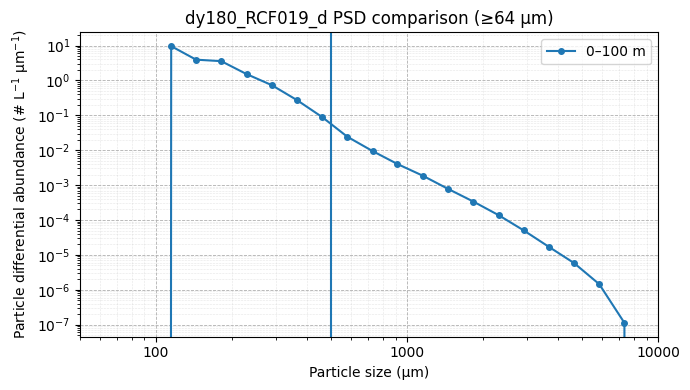

In [76]:
def plot_multi_psd(
    psd_list,
    labels=None,
    title=None,
    xlim=(50, 10000),
    show_markers=True,
    linestyle="-",
    linewidth=1.5,
    markersize=4,
    legend_loc="best"
):
    """
    Plot multiple PSDs on a single axis.

    Parameters
    ----------
    psd_list : list of pd.DataFrame
        Each dataframe must have columns: 'bin_mid' and 'norm_abundance'
    labels : list of str or None
        Legend labels (same length as psd_list). If None, auto-labels used.
    title : str or None
        Plot title
    xlim : tuple(float, float)
        X-axis limits (µm)
    show_markers : bool
        Whether to draw markers
    linestyle : str
        Line style for all curves
    linewidth : float
        Line width
    markersize : float
        Marker size (if show_markers=True)
    legend_loc : str
        Legend location (matplotlib loc string)
    """
    if labels is None:
        labels = [f"PSD {i+1}" for i in range(len(psd_list))]
    if len(labels) != len(psd_list):
        raise ValueError("labels must be the same length as psd_list")

    fig, ax = plt.subplots(figsize=(7, 4))

    for psd, lab in zip(psd_list, labels):
        ax.plot(
            psd["bin_mid"],
            psd["count_norm"],
            label=lab,
            linestyle=linestyle,
            linewidth=linewidth,
            marker="o" if show_markers else None,
            markersize=markersize,
        )

    ax.axvline(x=500)

    ax.set_xlabel("Particle size (µm)")
    ax.set_ylabel("Particle differential abundance (# L$^{-1}$ µm$^{-1}$)")
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(*xlim)

    ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1.0,)))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs="auto"))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(plt.NullFormatter())

    if title:
        ax.set_title(title)

    ax.grid(True, which="major", linestyle="--", linewidth=0.6)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.4, alpha=0.6)

    ax.legend(loc=legend_loc, frameon=True)
    plt.tight_layout()
    plt.show()

psd_all = psd_for_profile(
    DY180_UVP5_dat_del,
    "CAL2rcf19",
    depth_range=None,
    min_size_um=64
)

psd_0_100 = psd_for_profile(
    DY180_UVP5_dat_del,
    "CAL2rcf19",
    depth_range=(0,100),
    min_size_um=64
)

psd_100_600 = psd_for_profile(
    DY180_UVP5_dat_del,
    "CAL2rcf19",
    depth_range=(100,600),
    min_size_um=64
)

plot_multi_psd(
    [psd_0_100],
    labels=["0–100 m"],
    title="dy180_RCF019_d PSD comparison (≥64 µm)"
)


# 3.0 LISST Data loading and processing


In [83]:
# 1.2.2 LISST-Holo Data – Raw Processing + TSV Metadata Summary

# ---------------- CONSTANTS ----------------
pxl = 4.4
pxl_cm = 4.4e-4
v_cm3 = 1.5
v_L = v_cm3 / 1000


# ---------------- LOAD DATA ----------------
def load_lisst_data(folder_path: str):
    folder_path = Path(folder_path)

    # --- find TSV files ---
    tsv_files = [
        f for f in folder_path.glob("*.tsv")
        if "_black" not in f.name and "_summary" not in f.name
    ]

    print(f"LOADING DATA\n{'=' * 70}")
    print(f"Found {len(tsv_files)} TSV file(s)\n")

    dfs = []

    for f in tsv_files:
        df = pd.read_csv(f, sep="\t")
        df["tsv_file"] = f.name  # keep filename

        # ----- Remove first row if first column is [t] or [f] -----
        first_val = str(df.iloc[0, 0]).strip().lower()
        if first_val in ["[t]", "[f]"]:
            df = df.iloc[1:].reset_index(drop=True)

        # ----- Convert pixels to µm safely -----
        if "object_major" in df.columns:
            df["object_major"] = pd.to_numeric(df["object_major"], errors="coerce")
            df["object_major_um"] = df["object_major"] * pxl

        if "object_equivalent_diameter" in df.columns:
            df["object_equivalent_diameter"] = pd.to_numeric(
                df["object_equivalent_diameter"], errors="coerce"
            )
            df["object_ESD_um"] = df["object_equivalent_diameter"] * pxl

        # ----- Depth -----
        if "object_depth_min" in df.columns:
            # Filter out rows with missing depth before conversion
            df = df[df["object_depth_min"].notna()].reset_index(drop=True)

            # Convert to numeric
            df["object_depth_min"] = pd.to_numeric(
                df["object_depth_min"], errors="coerce"
            )
            df["depth"] = df["object_depth_min"]


        # ----- sample_id -----
        if "sample_id" in df.columns:
            df["sample_id"] = df["sample_id"].astype("category")

        # ----- Total images (force numeric) -----
        if "acq_num_of_images" in df.columns:
            df["acq_num_of_images"] = pd.to_numeric(
                df["acq_num_of_images"], errors="coerce"
            )

        dfs.append(df)

    all_data = pd.concat(dfs, ignore_index=True)

    print(f"Total particles loaded: {len(all_data)}")
    print(
        f"Unique samples: "
        f"{all_data['sample_id'].nunique() if 'sample_id' in all_data.columns else 'N/A'}\n"
    )

    return all_data


# ---------------- RUN LOADER ----------------
data_raw = load_lisst_data(r"temp_data\lisstholo_tsvs")


# ---------------- TSV METADATA SUMMARY ----------------
tsv_summary = (
    data_raw
    .groupby("tsv_file")
    .agg(
        sample_id=("sample_id", lambda x: x.dropna().iloc[0] if len(x.dropna()) > 0 else None),
        acq_num_of_images=("acq_num_of_images", lambda x: int(x.dropna().iloc[0]) if len(x.dropna()) > 0 else None),
        n_particles=("object_ESD_um", "count")
    )
    .reset_index()
)

tsv_summary


LOADING DATA
Found 12 TSV file(s)



C:\Users\aarfer\AppData\Local\Temp\ipykernel_45100\969275924.py:26: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,49,50,51,52,58,59,61,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep="\t")
C:\Users\aarfer\AppData\Local\Temp\ipykernel_45100\969275924.py:26: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,49,50,51,52,58,59,61,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep="\t")
C:\Users\aarfer\AppData\Local\Temp\ipykernel_45100\969275924.py:26: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,49,50,51,52,58,59,61,67,68,69) have mixed types. Specify dtype option on import or set low_memory=F

Total particles loaded: 228341
Unique samples: 12



,tsv_file,sample_id,acq_num_of_images,n_particles
0,ecotaxa_cal2rcf19_downcast_downcast.tsv,cal2rcf19_downcast,12465,13564
1,ecotaxa_r2rcf06_downcast.tsv,r2rcf06,12456,20494
2,ecotaxa_r3rcf10_downcast_downcast.tsv,r3rcf10_downcast,11729,60692
3,ecotaxa_r4rcf14_downcast_downcast.tsv,r4rcf14_downcast,11787,14710
4,ecotaxa_r5rcf18_downcast.tsv,r5rcf18,11593,10801
5,ecotaxa_s3rcf07_downcast.tsv,s3rcf07,4473,799
6,ecotaxa_s3rcf08_downcast_downcast.tsv,s3rcf08_downcast,14370,41914
7,ecotaxa_s3rcf09_downcast_downcast.tsv,s3rcf09_downcast,11834,14572
8,ecotaxa_s4rcf11_downcast_downcast.tsv,s4rcf11_downcast,13917,24286
9,ecotaxa_s5rcf15_downcast_downcast.tsv,s5rcf15_downcast,12373,6575


In [84]:
# ---------------- SIZE SPECTRA CONSTANTS ----------------
log10_bin_width = 0.065  # keep bin width for logarithmic spacing

# ---------------- SIZE SPECTRA FUNCTION ----------------
def calculate_size_spectra(data, total_images_col="acq_num_of_images", group_by="sample_id"):
    """
    Calculate normalized size spectra for LISST-Holo data (all depths combined).
    Bin edges are determined from the data itself.
    """
    data = data.copy()
    data["object_ESD_um"] = pd.to_numeric(data["object_ESD_um"], errors="coerce")
    data = data[data["object_ESD_um"].notna()]

    spectra_list = []

    # Determine bin edges from the min and max particle sizes in the data
    # MATCH R CODE: round to bin width grid
    min_size = data["object_ESD_um"].min()
    max_size = data["object_ESD_um"].max()

    # Calculate bin edges matching R's floor/ceiling approach
    min_log = np.floor(np.log10(min_size) / log10_bin_width) * log10_bin_width
    max_log = np.ceil(np.log10(max_size) / log10_bin_width) * log10_bin_width

    spectra_edges_um = 10 ** np.arange(
        min_log,
        max_log + log10_bin_width,  # add small amount to ensure max is included
        log10_bin_width
    )

    for grp_val, grp_df in data.groupby(group_by):
        total_images = grp_df[total_images_col].iloc[0]

        counts, bin_edges = np.histogram(grp_df["object_ESD_um"], bins=spectra_edges_um)

        bin_mids = np.sqrt(bin_edges[:-1] * bin_edges[1:])
        bin_widths = np.diff(bin_edges)

        count_norm = counts / (bin_widths * total_images * v_L)  # particles L^-1 µm^-1

        spectra_df = pd.DataFrame({
            group_by: grp_val,
            "bin_mid": bin_mids,
            "bin_min": bin_edges[:-1],
            "bin_max": bin_edges[1:],
            "bin_width": bin_widths,
            "count": counts,
            "count_norm": count_norm
        })

        spectra_list.append(spectra_df)

    return pd.concat(spectra_list, ignore_index=True)

# ---------------- RUN SPECTRA ----------------
all_spectra = calculate_size_spectra(data_raw)

# 3.1 LISST Data plotting

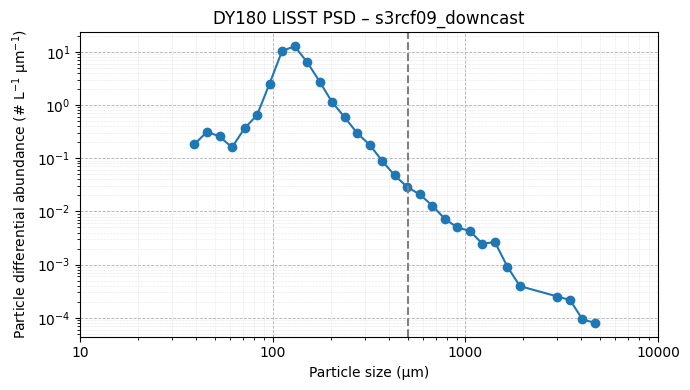

In [85]:
from matplotlib.ticker import LogLocator, ScalarFormatter
import matplotlib.pyplot as plt
import pandas as pd

# ---------------- UTILITY FUNCTION ----------------
def _first_existing(df, candidates, label):
    """Return first column name from candidates that exists in df.columns, else raise."""
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(
        f"Could not find a {label} column. Tried: {candidates}. "
        f"Available columns (first 30): {list(df.columns)[:30]}"
    )


# ---------------- PSD EXTRACTION ----------------
def psd_for_profile_lisst(df, profile_name, value_col="count_norm", profile_col=None,
                          min_size_um=32.0, drop_nonpositive=True):
    """
    Extract PSD for a LISST-Holo profile from `all_spectra` DataFrame.
    """

    # ---- pick profile/sample column automatically if not provided ----
    if profile_col is None:
        profile_col = _first_existing(
            df, ["sample_id", "Profile", "cast_id", "profile", "cast", "acq_id"],
            "profile/sample id"
        )

    # ---- subset by profile/sample ----
    sub = df.loc[df[profile_col] == profile_name].copy()
    if sub.empty:
        raise ValueError(f"No rows found for {profile_col} == {profile_name!r}")

    # ---- numeric ----
    sub[value_col] = pd.to_numeric(sub[value_col], errors="coerce")

    # ---- size cutoff ----
    sub = sub.loc[sub["bin_mid"] >= min_size_um].copy()

    # ---- drop nonpositive if requested ----
    if drop_nonpositive:
        sub = sub.loc[sub[value_col] > 0].copy()

    # ---- sort by size ----
    sub = sub.sort_values("bin_mid").reset_index(drop=True)

    # ---- output standardized columns ----
    bin_cols = ["bin_min", "bin_max", "bin_mid", "bin_width"]
    out = sub[bin_cols + [value_col]].copy()
    out = out.rename(columns={value_col: "count_norm"})

    return out


# ---------------- PSD PLOTTING ----------------
def plot_psd_lisst(psd, title=None):
    fig, ax = plt.subplots(figsize=(7, 4))

    ax.plot(
        psd["bin_mid"],
        psd["count_norm"],
        marker="o",
        linestyle="-"
    )
    ax.axvline(x=500, color="gray", linestyle="--")
    ax.set_xlabel("Particle size (µm)")
    ax.set_ylabel("Particle differential abundance (# L$^{-1}$ µm$^{-1}$)")

    # Log–log axes
    ax.set_xscale("log")
    ax.set_yscale("log")

    # ---- Force x-axis range and ticks ----
    ax.set_xlim(10, 10000)
    ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1.0,)))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs="auto"))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(plt.NullFormatter())

    if title:
        ax.set_title(title)

    ax.grid(True, which="major", linestyle="--", linewidth=0.6)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.4, alpha=0.6)

    plt.tight_layout()
    plt.show()


# ---------------- EXAMPLE: PLOT ONE SAMPLE ----------------
# Use your new 'all_spectra' DataFrame
sample_id = "s3rcf09_downcast"

lisst_psd_sample = psd_for_profile_lisst(
    all_spectra,
    profile_name=sample_id,
    min_size_um=32.0
)

plot_psd_lisst(lisst_psd_sample, title=f"DY180 LISST PSD – {sample_id}")


# 4.0 LISST/UVP Intercomp

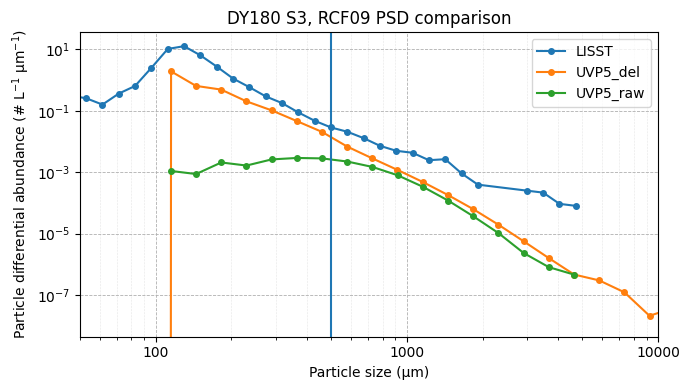

In [86]:
lisst_psd_0_100_20240603_1900 = psd_for_profile_lisst(DY180_LISST_data_AF,
                      profile_name="LH20240608002840_downcast")

#lisst_psd_0_100_20240603_1900 = psd_for_profile_lisst(DY180_LISST_data_AF,
#                      profile_name="LH20240608002840_descend")

uvp_psd_0_100_20240603_1900 = psd_for_profile(
    DY180_UVP5_dat_del,
    profile_name="s3rcf09")

DY180_UVP5_dat_raw_adj_bin

uvp_psd_0_100_20240603_1900_2 = psd_for_profile(
    DY180_UVP5_dat_raw_adj_bin,
    profile_name="s3rcf09")

plot_multi_psd(
    [lisst_psd_0_100_20240603_1900, uvp_psd_0_100_20240603_1900, uvp_psd_0_100_20240603_1900_2],
    labels=["LISST", "UVP5_del","UVP5_raw"],
    title="DY180 S3, RCF09 PSD comparison"
)

In [87]:
print(DY180_LISST_data_AF["acq_id"].unique())

['LH20240608002840_downcast']


In [89]:
# Filter a sample if needed, or keep all
py_spectra_export = all_spectra.copy()

# Rename columns to match R output
py_spectra_export = py_spectra_export.rename(columns={
    "sample_id": "Profile"
})

# Select/reorder columns as in R output
columns_order = ["Profile", "bin_min", "bin_max", "bin_mid", "bin_width", "count_norm"]
py_spectra_export = py_spectra_export[columns_order]

# Save as TSV (like your R output)
py_spectra_export.to_csv(
    "temp_data/size_spectra_python_export.tsv",
    sep="\t",
    index=False
)

print("Python size spectra exported to size_spectra_python_export.tsv")


Python size spectra exported to size_spectra_python_export.tsv
